In [11]:
import numpy as np
import torch
from torch import nn
from torch.nn import functional as F
import os
import scipy.io as scio
import torch.optim as optim
from tqdm import tqdm
from spatialspectral import EndmemberGuidedUnmixingNetwork
import matplotlib.pyplot as plt

device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)

In [12]:
Pure_TrSet = scio.loadmat('Data/Pure_TrSet.mat')
Mixed_TrSet = scio.loadmat('Data/Mixed_TrSet.mat')
TrLabel = scio.loadmat('Data/TrLabel.mat')
TeLabel = scio.loadmat('Data/TeLabel.mat')

Pure_TrSet = Pure_TrSet['Pure_TrSet']
Mixed_TrSet = Mixed_TrSet['Mixed_TrSet']
TrLabel = TrLabel['TrLabel']
TeLabel = TeLabel['TeLabel']

Pure_TrSet = torch.from_numpy(np.array(Pure_TrSet, dtype=np.float32)).to(device=device)
Mixed_TrSet = torch.from_numpy(np.array(Mixed_TrSet, dtype=np.float32)).to(device=device)
TrLabel = torch.from_numpy(np.array(TrLabel, dtype=np.float32)).to(device=device)
TeLabel = torch.from_numpy(np.array(TeLabel, dtype=np.float32)).to(device=device)

Y_train = TrLabel
Y_test = TeLabel

x_pure_image = Pure_TrSet.view(-1, 1, 1, 224).permute(0, 3, 1, 2)
x_mixed_image = Mixed_TrSet.view(1, 200, 200, 224).permute(0, 3, 1, 2)

egu_net = EndmemberGuidedUnmixingNetwork().to(device=device)
optimizer = optim.Adam(egu_net.parameters(), lr=0.005)

In [13]:
def loss_fn(egunet: EndmemberGuidedUnmixingNetwork):
    global Y_train
    cost = 0.0
    cost += torch.mean(torch.nn.functional.cross_entropy(egunet.e_net.abundances, Y_train))
    cost += torch.mean(torch.square(egunet.ur_net.recon - x_mixed_image))
    return cost

In [14]:
running_loss = 0.0
for epoch in tqdm(range(200)):
    optimizer.zero_grad()
    egu_net.forward(x_pure=x_pure_image, x_mixed=x_mixed_image)
    loss = loss_fn(egunet=egu_net)
    loss.backward()
    optimizer.step()
    
    running_loss += loss.item()
    if epoch % 10 == 0:
        print(f"{epoch + 1}, running_loss: {running_loss / 10}")
        running_loss = 0.0

  1%|          | 2/200 [00:00<00:35,  5.55it/s]

1, running_loss: 0.2123734474182129


  6%|▌         | 12/200 [00:01<00:22,  8.22it/s]

11, running_loss: 1.5517139554023742


 11%|█         | 22/200 [00:02<00:20,  8.61it/s]

21, running_loss: 1.3405497670173645


 16%|█▌        | 32/200 [00:03<00:19,  8.67it/s]

31, running_loss: 1.3036015510559082


 21%|██        | 42/200 [00:05<00:18,  8.66it/s]

41, running_loss: 1.2852543711662292


 26%|██▌       | 52/200 [00:06<00:17,  8.69it/s]

51, running_loss: 1.2738625884056092


 31%|███       | 62/200 [00:07<00:15,  8.72it/s]

61, running_loss: 1.2667171835899353


 36%|███▌      | 72/200 [00:08<00:14,  8.96it/s]

71, running_loss: 1.2605757594108582


 41%|████      | 82/200 [00:09<00:12,  9.21it/s]

81, running_loss: 1.2362220525741576


 46%|████▌     | 92/200 [00:10<00:11,  9.24it/s]

91, running_loss: 1.216457438468933


 51%|█████     | 102/200 [00:11<00:10,  9.23it/s]

101, running_loss: 1.2045825481414796


 56%|█████▌    | 112/200 [00:12<00:09,  9.24it/s]

111, running_loss: 1.196911334991455


 61%|██████    | 122/200 [00:13<00:08,  9.19it/s]

121, running_loss: 1.1917776584625244


 66%|██████▌   | 132/200 [00:15<00:07,  9.19it/s]

131, running_loss: 1.1884232401847838


 71%|███████   | 142/200 [00:16<00:06,  8.34it/s]

141, running_loss: 1.1873361825942994


 76%|███████▌  | 152/200 [00:17<00:05,  8.52it/s]

151, running_loss: 1.1854220151901245


 81%|████████  | 162/200 [00:18<00:04,  8.65it/s]

161, running_loss: 1.1845665574073792


 86%|████████▌ | 172/200 [00:19<00:03,  8.70it/s]

171, running_loss: 1.1841742634773254


 91%|█████████ | 182/200 [00:20<00:02,  8.66it/s]

181, running_loss: 1.1839766025543212


 96%|█████████▌| 192/200 [00:22<00:00,  8.69it/s]

191, running_loss: 1.1838572382926942


100%|██████████| 200/200 [00:22<00:00,  8.72it/s]


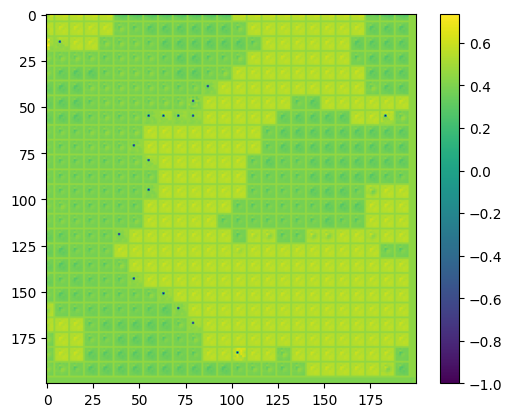

In [27]:
plt.imshow(egu_net.ur_net.recon[0, 100, :, :].detach().cpu().numpy())
plt.colorbar()

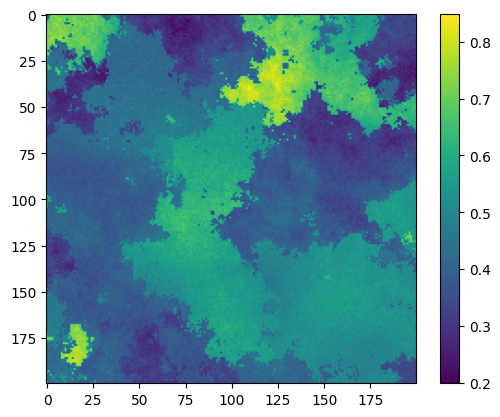

In [26]:
plt.imshow(x_mixed_image[0, 100, :, :].detach().cpu().numpy())
plt.colorbar()